## Modelling Experiment

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import RandomOverSampler, SMOTE
from collections import Counter
import pickle
import gzip
seed = 42

In [50]:
df = pd.read_csv('ObesityDataSet2.csv')
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,24,1.58,65.29,yes,no,2.03,2.74,Sometimes,no,2.00,no,1.28,1.019,no,Public_Transportation,Overweight_Level_II
1,Male,23,1.65,66.00,no,no,3.00,3.00,Sometimes,no,2.00,no,3.00,0.000,no,Public_Transportation,Normal_Weight
2,Female,21,1.69,51.26,yes,yes,3.00,3.18,Frequently,no,1.91,no,0.48,0.625,no,Public_Transportation,Insufficient_Weight
3,Female,22,1.69,65.00,yes,yes,2.00,3.00,Sometimes,no,2.00,no,1.00,1.000,Sometimes,Public_Transportation,Normal_Weight
4,Female,23,1.61,82.64,yes,yes,2.96,1.00,Sometimes,no,2.98,no,0.74,2.000,Sometimes,Public_Transportation,Obesity_Type_I


In [51]:
#Deskripsi Statistik
df.shape
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          1056 non-null   object 
 1   Age                             1056 non-null   object 
 2   Height                          1056 non-null   float64
 3   Weight                          1056 non-null   float64
 4   family_history_with_overweight  1056 non-null   object 
 5   FAVC                            1056 non-null   object 
 6   FCVC                            1019 non-null   float64
 7   NCP                             1056 non-null   float64
 8   CAEC                            1056 non-null   object 
 9   SMOKE                           1056 non-null   object 
 10  CH2O                            1056 non-null   float64
 11  SCC                             1056 non-null   object 
 12  FAF                             10

,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,1056.000000,1056.000000,1019.000000,1056.000000,1056.000000,1056.000000,1056.000000
mean,1.700066,86.497633,2.421374,2.651686,1.998002,0.987528,0.642227
std,0.091560,26.181219,0.537591,0.804457,0.612930,0.850452,0.615533
min,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,1.630000,66.000000,2.000000,2.525000,1.530000,0.110000,0.000000
50%,1.700000,82.635000,2.390000,3.000000,2.000000,1.000000,0.583000
75%,1.760000,107.965000,3.000000,3.000000,2.442500,1.602500,1.000000
max,1.950000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


In [52]:
#Cek data duplikat
print(df.duplicated().sum())

10


In [53]:
df.drop_duplicates(inplace=True)

In [54]:
#Cek missing values
df.isnull().sum()

,0
Gender,0
Age,0
Height,0
Weight,0
family_history_with_overweight,0
FAVC,0
FCVC,37
NCP,0
CAEC,0
SMOKE,0


In [55]:
#Drop missing values
df.dropna(inplace=True)

In [56]:
#Mengubah variabel Age menjadi numerik
df['Age'] = df['Age'].str.replace(' years', '', regex=False)
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')

print(df['Age'].unique())


[24 23 21 22 26 18 25 20 32 19 38 34 44 17 41 29 31 39 27 16 40 33 30 37
 35 36 15 28 55 46 42 43 51 45 48]


In [57]:
#Mengubah variabel float menjadi integer
#Frekuensi konsumsi sayuran, jumlah makan per hari tidak mungkin desimal
df['FCVC'] = df['FCVC'].round().astype(int)
df['NCP'] = df['NCP'].round().astype(int)
df['CH2O'] = df['CH2O'].round().astype(int)
df['FAF'] = df['FAF'].round().astype(int)
df['TUE'] = df['TUE'].round().astype(int)

In [58]:
#Membuat list terpisah untuk fitur numerical dan categorical
categorical = []
numerical = []

for i in df.columns:
    if df[i].dtype == 'object':
        categorical.append(i)
    else:
        numerical.append(i)

print(f'Categorical: {categorical}')
print(f'Numerical: {numerical}')

Categorical: ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'NObeyesdad']
Numerical: ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']


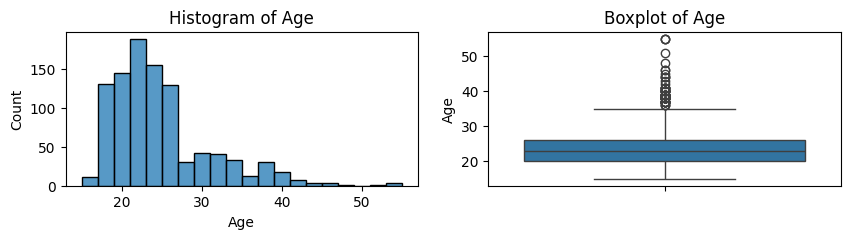

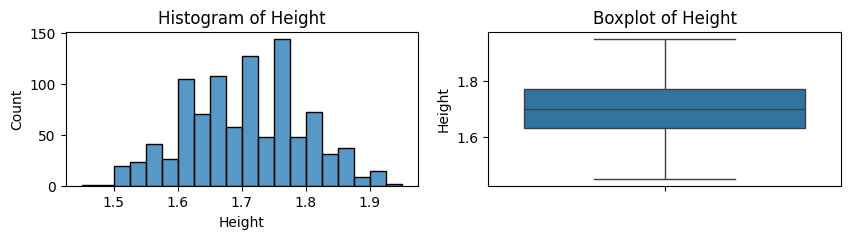

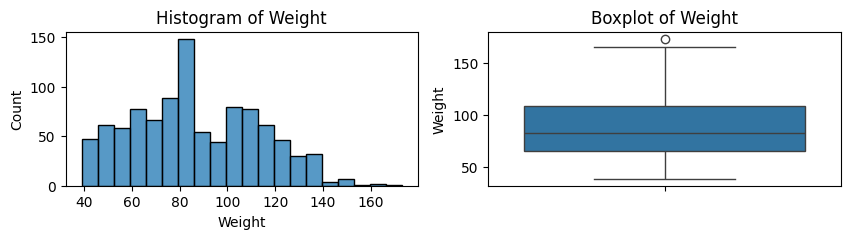

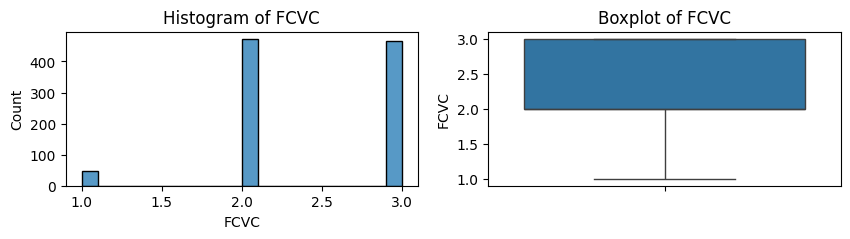

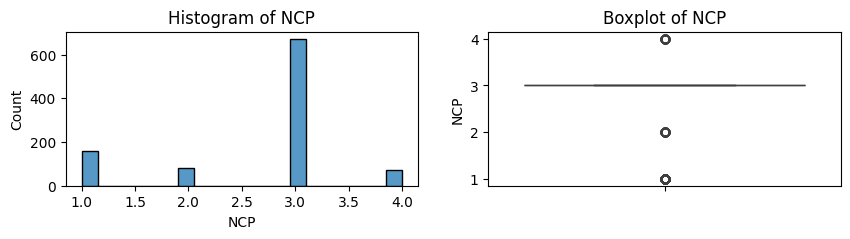

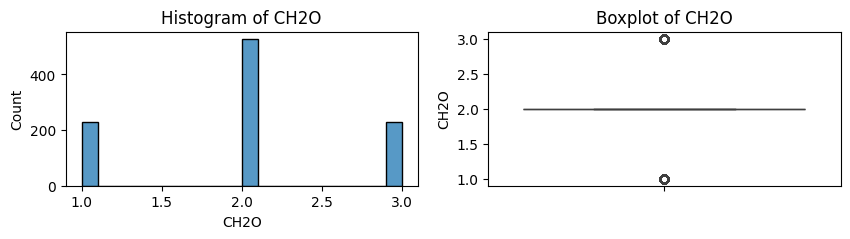

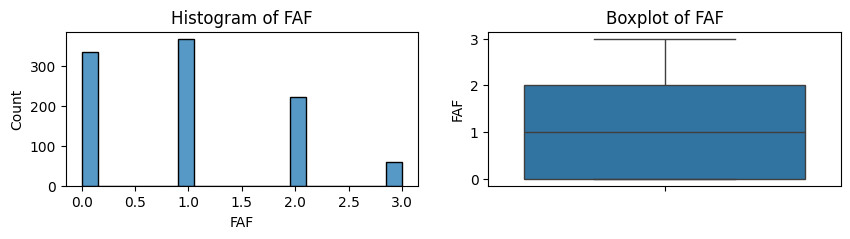

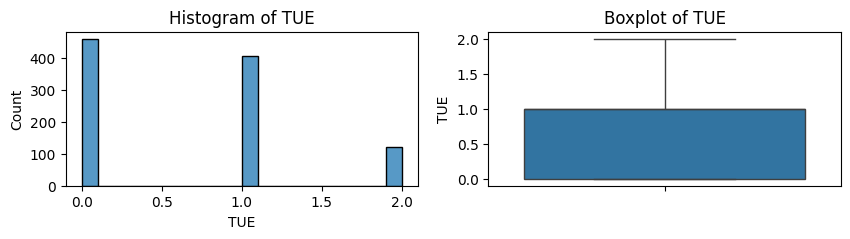

In [59]:
def check_dist(df, column):
    for i in column:
        plt.figure(figsize=(10,2))
        plt.subplot(1,2,1)
        sns.histplot(df[i], bins=20)
        plt.title(f'Histogram of {i}')

        plt.subplot(1,2,2)
        sns.boxplot(y=df[i])
        plt.title(f'Boxplot of {i}')
        plt.show()

check_dist(df[numerical], numerical)

In [60]:
for col in categorical:
    print(f"\nUnique values in '{col}':")
    print(df[col].unique())


Unique values in 'Gender':
['Female' 'Male']

Unique values in 'family_history_with_overweight':
['yes' 'no']

Unique values in 'FAVC':
['no' 'yes']

Unique values in 'CAEC':
['Sometimes' 'Frequently' 'no' 'Always']

Unique values in 'SMOKE':
['no' 'yes']

Unique values in 'SCC':
['no' 'yes']

Unique values in 'CALC':
['no' 'Sometimes' 'Frequently' 'Always']

Unique values in 'MTRANS':
['Public_Transportation' 'Bike' 'Automobile' 'Motorbike' 'Walking']

Unique values in 'NObeyesdad':
['Overweight_Level_II' 'Normal_Weight' 'Insufficient_Weight'
 'Obesity_Type_I' 'Obesity_Type_III' 'Overweight_Level_I'
 'Obesity_Type_II']


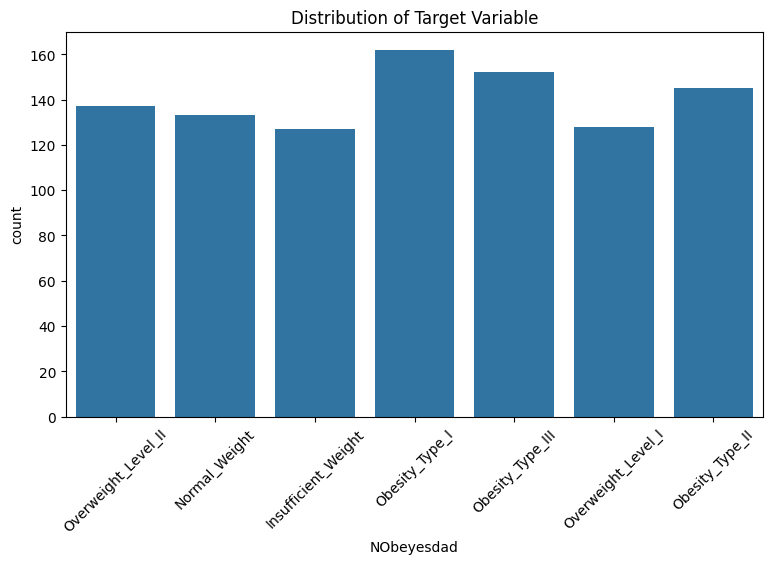

In [61]:
#Cek distribusi variabel target
plt.figure(figsize=(9, 5))
sns.countplot(data=df, x='NObeyesdad')
plt.title('Distribution of Target Variable')
plt.xticks(rotation=45)
plt.show()

In [62]:
#Label encoding (mapping) untuk fitur binary
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})
df['FAVC'] = df['FAVC'].map({'yes': 1, 'no': 0})
df['SMOKE'] = df['SMOKE'].map({'yes': 1, 'no': 0})
df['SCC'] = df['SCC'].map({'yes': 1, 'no': 0})
df['family_history_with_overweight'] = df['family_history_with_overweight'].map({'yes': 1, 'no': 0})

df['CAEC'] = df['CAEC'].map({'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3})
df['CALC'] = df['CALC'].map({'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3})


df['MTRANS'] = df['MTRANS'].map({
    'Automobile': 0,
    'Bike': 1,
    'Motorbike': 2,
    'Public_Transportation': 3,
    'Walking': 4
})


df['NObeyesdad'] = df['NObeyesdad'].map({
    'Insufficient_Weight': 0,
    'Normal_Weight': 1,
    'Obesity_Type_I': 2,
    'Obesity_Type_II': 3,
    'Obesity_Type_III': 4,
    'Overweight_Level_I': 5,
    'Overweight_Level_II': 6
})

#Simpan mapping
target_mapping = {
    0: 'Insufficient_Weight',
    1: 'Normal_Weight',
    2: 'Obesity_Type_I',
    3: 'Obesity_Type_II',
    4: 'Obesity_Type_III',
    5: 'Overweight_Level_I',
    6: 'Overweight_Level_II'
}


In [63]:
#Splitting
x = df.drop(columns=['NObeyesdad'])
y = df['NObeyesdad']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = seed)

In [64]:
#Menyimpan fitur asli untuk keperluan prediksi di streamlit
x_test_raw = x_test.copy()

In [65]:
#Scaling
robust = RobustScaler()
x_train[numerical] = robust.fit_transform(x_train[numerical])
x_test[numerical] = robust.transform(x_test[numerical])
x_train.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
1034,1,2.333333,0.461538,0.851768,1,1,0.0,0.0,1,0,0.0,0,0.0,-1.0,1,0
826,1,-0.166667,1.153846,0.945351,1,1,1.0,-1.0,1,0,-1.0,0,-0.5,-1.0,1,3
369,0,-0.666667,-1.461538,-0.896059,0,1,0.0,1.0,1,0,-1.0,0,1.0,-1.0,1,3
957,1,0.666667,1.000000,0.389808,1,1,1.0,-2.0,2,0,0.0,0,0.5,0.0,1,4
576,0,-0.500000,-0.153846,-0.798190,0,0,1.0,0.0,1,0,0.0,0,0.5,0.0,1,3


In [66]:
#Random oversampling -> to handle class imbalance
ros = RandomOverSampler(random_state=seed)
x_train, y_train = ros.fit_resample(x_train, y_train)
print("result", Counter(y_train))

result Counter({3: 135, 1: 135, 6: 135, 0: 135, 2: 135, 4: 135, 5: 135})


In [67]:
#Model 1: Decision Tree Classifier
dt = DecisionTreeClassifier(criterion='gini', max_depth=None, random_state=42)
dt.fit(x_train, y_train)
y_pred_dt = dt.predict(x_test)

print(classification_report(y_test, y_pred_dt))
print(confusion_matrix(y_test, y_pred_dt))
print(accuracy_score(y_test, y_pred_dt))


              precision    recall  f1-score   support

           0       0.95      0.91      0.93        23
           1       0.77      0.71      0.74        24
           2       0.83      0.93      0.88        27
           3       0.97      0.93      0.95        30
           4       1.00      1.00      1.00        32
           5       0.64      0.86      0.73        21
           6       0.97      0.82      0.89        40

    accuracy                           0.88       197
   macro avg       0.88      0.88      0.88       197
weighted avg       0.89      0.88      0.89       197

[[21  2  0  0  0  0  0]
 [ 1 17  0  0  0  6  0]
 [ 0  0 25  1  0  0  1]
 [ 0  0  2 28  0  0  0]
 [ 0  0  0  0 32  0  0]
 [ 0  3  0  0  0 18  0]
 [ 0  0  3  0  0  4 33]]
0.883248730964467


In [68]:
#XGBoost
xgb = XGBClassifier()
xgb.fit(x_train, y_train)
y_pred_xgb = xgb.predict(x_test)
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))
print(accuracy_score(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        23
           1       0.95      0.75      0.84        24
           2       0.96      1.00      0.98        27
           3       1.00      0.97      0.98        30
           4       1.00      1.00      1.00        32
           5       0.81      1.00      0.89        21
           6       0.97      0.93      0.95        40

    accuracy                           0.95       197
   macro avg       0.94      0.95      0.94       197
weighted avg       0.95      0.95      0.95       197

[[23  0  0  0  0  0  0]
 [ 2 18  0  0  0  3  1]
 [ 0  0 27  0  0  0  0]
 [ 0  0  1 29  0  0  0]
 [ 0  0  0  0 32  0  0]
 [ 0  0  0  0  0 21  0]
 [ 0  1  0  0  0  2 37]]
0.949238578680203


In [75]:
#Simpan best model dengan pickle
with gzip.open('xgb.pkl', 'wb') as f:
    pickle.dump(xgb, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(robust, f)

## Pipeline

In [73]:
#Split kembali (untuk keperluan pipeline saja)
x = df.drop(columns=['NObeyesdad'])
y = df['NObeyesdad']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = seed)

#Oversample hanya pada raw data
ros = RandomOverSampler(random_state=seed)
x_train, y_train = ros.fit_resample(x_train, y_train)

In [74]:
#Pipeline untuk best model
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, FunctionTransformer
from xgboost import XGBClassifier

numerical = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
non_numerical = list(set(x_train.columns) - set(numerical))

preprocessor = ColumnTransformer([
    ("scale_num", RobustScaler(), numerical),
    ("passthrough_cat", FunctionTransformer(validate=False), non_numerical)
])

pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("model", XGBClassifier())
])
pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)

with open("pipeline.pkl", "wb") as f:
    pickle.dump(pipeline, f)

## Testcase

In [71]:
#Mengambil test case untuk dicek di aplikasi streamlit
test_case_1 = x_test.iloc[8]
actual_1 = y_test.iloc[8]
raw_1 = x_test_raw.iloc[8]
print(raw_1)
input1 = np.array(test_case_1).reshape(1, -1)
pred1 = xgb.predict(input1)
print(f"Test Case 1 Prediction: {pred1}")
print(f"Actual Label      : {actual_1}")


Gender                             1.00
Age                               48.00
Height                             1.74
Weight                            84.73
family_history_with_overweight     1.00
FAVC                               1.00
FCVC                               3.00
NCP                                3.00
CAEC                               1.00
SMOKE                              0.00
CH2O                               1.00
SCC                                0.00
FAF                                0.00
TUE                                0.00
CALC                               0.00
MTRANS                             0.00
Name: 777, dtype: float64
Test Case 1 Prediction: [6]
Actual Label      : 6


In [72]:
test_case_2 = x_test.iloc[5]
actual_2 = y_test.iloc[5]
raw_2 = x_test_raw.iloc[5]
print(raw_2)
input2 = np.array(test_case_2).reshape(1, -1)
pred2 = xgb.predict(input2)
print(f"Test Case 2 Prediction: {pred2}")
print(f"Actual Label      : {actual_2}")

Gender                             1.00
Age                               20.00
Height                             1.56
Weight                            45.00
family_history_with_overweight     0.00
FAVC                               0.00
FCVC                               2.00
NCP                                3.00
CAEC                               1.00
SMOKE                              0.00
CH2O                               2.00
SCC                                0.00
FAF                                1.00
TUE                                1.00
CALC                               1.00
MTRANS                             3.00
Name: 634, dtype: float64
Test Case 2 Prediction: [1]
Actual Label      : 1
